# Dogs vs. Cats Redux

## Kaggle Competition

In [36]:
%matplotlib inline
#path = 'data/dogscats/sample/'
path = 'data/dogscats/'

train_path = path + 'train/'
valid_path = path + 'valid/'
test_path = path + 'test/'
results_path = path + 'results/'
model_path = path + 'models/'

In [37]:
from utils import *
from vgg16 import Vgg16

In [38]:
batch_size = 64
num_epoch = 8

In [39]:
vgg = Vgg16()
batches = vgg.get_batches(path+'train', batch_size=batch_size)
val_batches = vgg.get_batches(path+'valid', batch_size=batch_size*2)

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [40]:
vgg.finetune(batches)
vgg.model.optimizer.lr = 0.005
vgg.model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_6 (Lambda)                (None, 3, 224, 224)   0           lambda_input_6[0][0]             
____________________________________________________________________________________________________
zeropadding2d_66 (ZeroPadding2D) (None, 3, 226, 226)   0           lambda_6[0][0]                   
____________________________________________________________________________________________________
convolution2d_66 (Convolution2D) (None, 64, 224, 224)  0           zeropadding2d_66[0][0]           
____________________________________________________________________________________________________
zeropadding2d_67 (ZeroPadding2D) (None, 64, 226, 226)  0           convolution2d_66[0][0]           
___________________________________________________________________________________________

In [41]:
vgg.fit(batches, val_batches, nb_epoch=num_epoch)

Epoch 1/8
23000/23000 [==============================] - 639s - loss: 0.2485 - acc: 0.9715 - val_loss: 0.1431 - val_acc: 0.9840
Epoch 2/8
23000/23000 [==============================] - 640s - loss: 0.2693 - acc: 0.9768 - val_loss: 0.1517 - val_acc: 0.9815
Epoch 3/8
23000/23000 [==============================] - 640s - loss: 0.2707 - acc: 0.9779 - val_loss: 0.2110 - val_acc: 0.9805
Epoch 4/8
23000/23000 [==============================] - 640s - loss: 0.2792 - acc: 0.9779 - val_loss: 0.4031 - val_acc: 0.9720
Epoch 5/8
23000/23000 [==============================] - 640s - loss: 0.2774 - acc: 0.9788 - val_loss: 0.1850 - val_acc: 0.9855
Epoch 6/8
23000/23000 [==============================] - 642s - loss: 0.2729 - acc: 0.9797 - val_loss: 0.2084 - val_acc: 0.9835
Epoch 7/8
23000/23000 [==============================] - 630s - loss: 0.2561 - acc: 0.9814 - val_loss: 0.1183 - val_acc: 0.9890
Epoch 8/8
23000/23000 [==============================] - 629s - loss: 0.2673 - acc: 0.9808 - val_loss: 0

In [42]:
vgg.model.save_weights(model_path+'finetune.h5')

In [43]:
batches, preds = vgg.test(test_path, batch_size=batch_size*2)
filenames = batches.filenames

isdog = preds[:,1]
isdog = isdog.clip(min=0.05, max=0.95)
ids = np.array([int(f[8:f.find('.')]) for f in filenames])

Found 12500 images belonging to 1 classes.


In [44]:
subm = np.stack([ids, isdog], axis=1)

In [45]:
submission_file_name = results_path+'dogscats_sub1.csv'
np.savetxt(submission_file_name, subm, fmt='%d,%.5f', header='id,label', comments='')

In [46]:
imgs = next(batches)

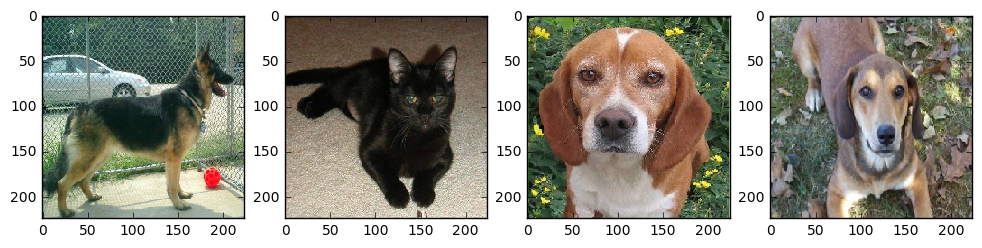

In [47]:
plots(imgs[:4])

In [48]:
print preds[:4]
print filenames[:4]

[[ 0.  1.]
 [ 1.  0.]
 [ 1.  0.]
 [ 0.  1.]]
['unknown/1.jpg', 'unknown/10.jpg', 'unknown/100.jpg', 'unknown/1000.jpg']


In [49]:
batches, preds = vgg.test(valid_path, batch_size=batch_size*2)

Found 2000 images belonging to 2 classes.


In [50]:
filenames = batches.filenames
expected_labels = batches.classes

my_preds = preds[:,0]
my_labels = np.round(1-my_preds)

In [51]:
from keras.preprocessing import image

def plots_idx(idx, titles=None):
    plots([image.load_img(valid_path + filenames[i]) for i in idx], titles=titles)
    
n_view = 4

Found 1972 correct lables


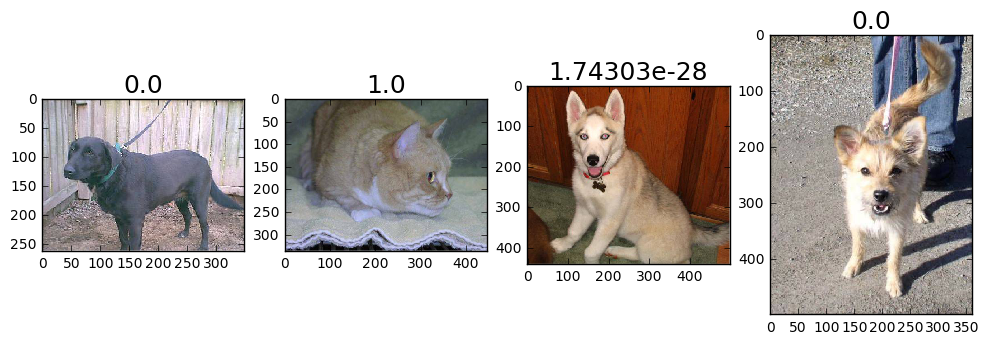

In [52]:
correct = np.where(my_labels == expected_labels)[0]
print "Found %d correct lables" % len(correct)
idx = permutation(correct)[:n_view]
plots_idx(idx, my_preds[idx])

Found 28 incorrect lables


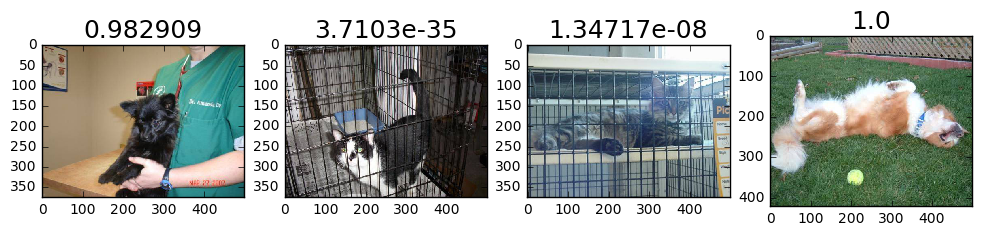

In [53]:
incorrect = np.where(my_labels != expected_labels)[0]
print "Found %d incorrect lables" % len(incorrect)
idx = permutation(incorrect)[:n_view]
plots_idx(idx, my_preds[idx])

Found 1006 correct cats labels


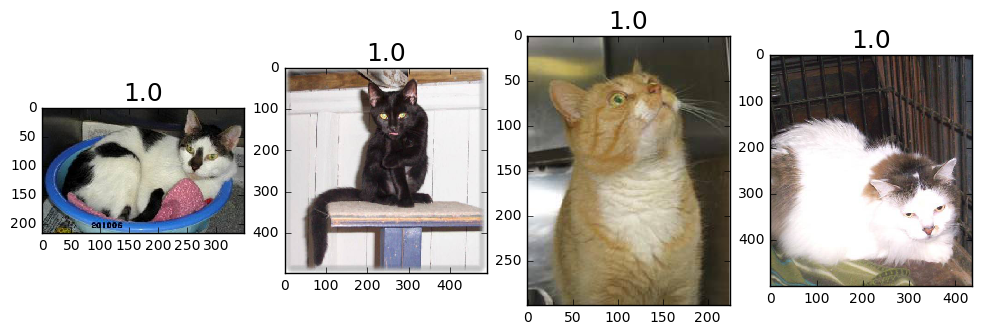

In [54]:
correct_cats = np.where((my_labels==0) & (my_labels==expected_labels))[0]
print "Found %d correct cats labels" % len(correct_cats)
most_correct_cats = np.argsort(my_preds[correct_cats])[::-1][:n_view]
plots_idx(correct_cats[most_correct_cats], my_preds[correct_cats][most_correct_cats])

Found 966 correct dogs labels


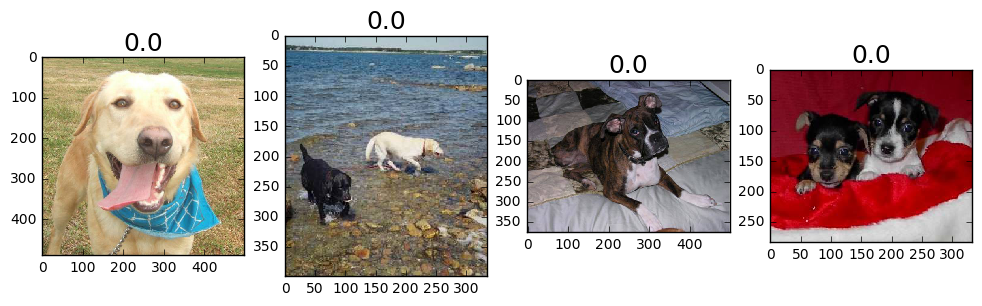

In [55]:
correct_dogs = np.where((my_labels==1) & (my_labels==expected_labels))[0]
print "Found %d correct dogs labels" % len(correct_dogs)
most_correct_dogs = np.argsort(my_preds[correct_dogs])[:n_view]
plots_idx(correct_dogs[most_correct_dogs], my_preds[correct_dogs][most_correct_dogs])

Found 14 incorrect cats


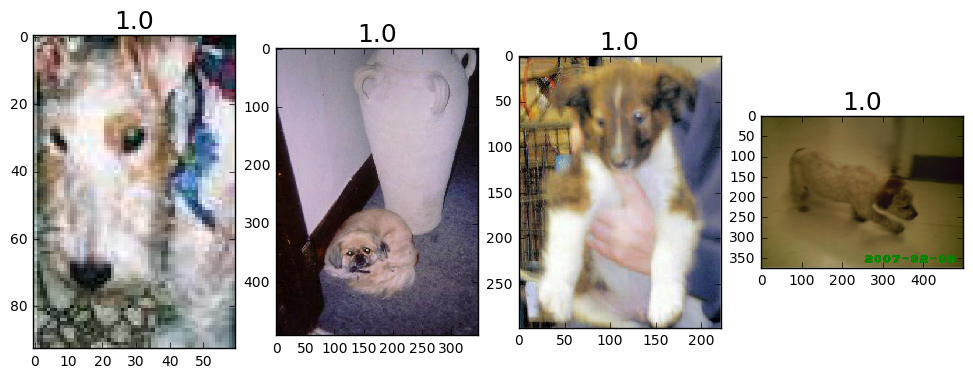

In [56]:
incorrect_cats = np.where((my_labels==0) & (my_labels!=expected_labels))[0]
print "Found %d incorrect cats" % len(incorrect_cats)
if len(incorrect_cats):
    most_incorrect_cats = np.argsort(my_preds[incorrect_cats])[::-1][:n_view]
    plots_idx(incorrect_cats[most_incorrect_cats], my_preds[incorrect_cats][most_incorrect_cats])

Found 14 incorrect dogs


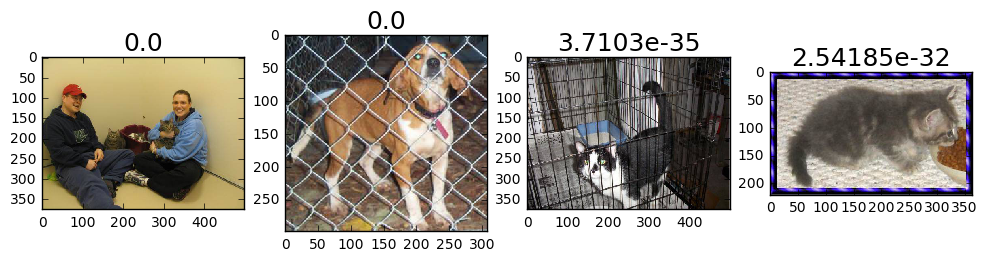

In [57]:
incorrect_dogs = np.where((my_labels==1) & (my_labels!=expected_labels))[0]
print "Found %d incorrect dogs" % len(incorrect_dogs)
if len(incorrect_dogs):
    most_incorrect_dogs = np.argsort(my_preds[incorrect_dogs])[:n_view]
    plots_idx(incorrect_dogs[most_incorrect_dogs], my_preds[incorrect_dogs][most_incorrect_dogs])

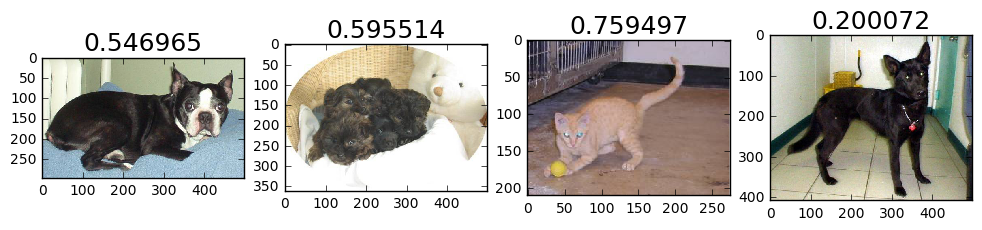

In [58]:
most_uncertain = np.argsort(np.abs(my_preds-0.5))
plots_idx(most_uncertain[:n_view], my_preds[most_uncertain])

[[1006   14]
 [  14  966]]


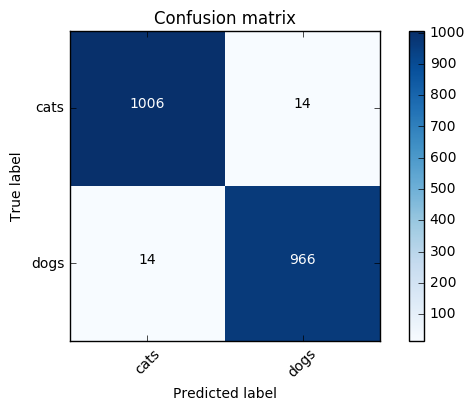

In [59]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(expected_labels, my_labels)
plot_confusion_matrix(cm, batches.class_indices)

## Dropout & Data Augmentation

There doesn't seem to be overfitting going on yet. Start by removing dropout to observe overfitting, then correct with data augmentation.

TODO:

1. Remove dropout and retrain until overfitting occurs
2. Add data augmentation and train (hopefully longer) until overfitting occurs
3. Add dropout, and train (even longer) until overfitting occurs
4. Add batchnorm?

### Remove Dropout

In [72]:
model = vgg_ft(2)
model.load_weights(model_path+'finetune.h5')
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_9 (Lambda)                (None, 3, 224, 224)   0           lambda_input_9[0][0]             
____________________________________________________________________________________________________
zeropadding2d_105 (ZeroPadding2D)(None, 3, 226, 226)   0           lambda_9[0][0]                   
____________________________________________________________________________________________________
convolution2d_105 (Convolution2D)(None, 64, 224, 224)  0           zeropadding2d_105[0][0]          
____________________________________________________________________________________________________
zeropadding2d_106 (ZeroPadding2D)(None, 64, 226, 226)  0           convolution2d_105[0][0]          
___________________________________________________________________________________________

In [73]:
layers = model.layers

# get all conv layers
last_conv_idx = [index for index,layer in enumerate(layers)
                        if type(layer) == Convolution2D][-1]
conv_layers = layers[:last_conv_idx+1]

# create model on just conv layers
conv_model = Sequential(conv_layers)

batches = vgg.get_batches(path+'train', batch_size=batch_size)
val_batches = vgg.get_batches(path+'valid', batch_size=batch_size*2)

train_features = conv_model.predict_generator(batches, batches.nb_sample)
val_features = conv_model.predict_generator(val_batches, val_batches.nb_sample)

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [74]:
save_array(model_path + 'train_convlayer_features.h5', train_features)
save_array(model_path + 'valid_convlayer_features.h5', val_features)

In [75]:
val_classes = val_batches.classes
train_classes = batches.classes
val_labels = onehot(val_classes)
train_labels = onehot(train_classes)

save_array(model_path + 'train_labels.h5', train_labels)
save_array(model_path + 'valid_labels.h5', val_labels)

In [76]:
train_features = load_array(model_path + 'train_convlayer_features.h5')
val_features = load_array(model_path + 'valid_convlayer_features.h5')
train_labels = load_array(model_path + 'train_labels.h5')
valid_labels = load_array(model_path + 'valid_labels.h5')

In [77]:
train_features.shape

(23000, 512, 14, 14)

In [78]:
fc_layers = layers[last_conv_idx+1:]

# Copy the weights from the pre-trained model.
# NB: Since we're removing dropout, we want to half the weights
def proc_wgts(layer): return [o/2 for o in layer.get_weights()]

In [79]:
def fc_model(p):
    model = Sequential([
            MaxPooling2D((2,2), strides=(2, 2), input_shape=conv_layers[-1].output_shape[1:]),
            Flatten(),
            Dense(4096, activation='relu'),
            Dropout(p),
            Dense(4096, activation='relu'),
            Dropout(p),
            Dense(2, activation='softmax')
        ])
    
    for l1,l2 in zip(model.layers, fc_layers): l1.set_weights(proc_wgts(l2))
    
    model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [80]:
no_drop = fc_model(0)
no_drop.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
maxpooling2d_53 (MaxPooling2D)   (None, 512, 7, 7)     0           maxpooling2d_input_8[0][0]       
____________________________________________________________________________________________________
flatten_17 (Flatten)             (None, 25088)         0           maxpooling2d_53[0][0]            
____________________________________________________________________________________________________
dense_55 (Dense)                 (None, 4096)          102764544   flatten_17[0][0]                 
____________________________________________________________________________________________________
dropout_33 (Dropout)             (None, 4096)          0           dense_55[0][0]                   
___________________________________________________________________________________________

In [81]:
no_drop.fit(train_features, train_labels, nb_epoch=8, batch_size=batch_size,
             validation_data=(val_features, val_labels))

Train on 23000 samples, validate on 2000 samples
Epoch 1/8
23000/23000 [==============================] - 42s - loss: 0.8767 - acc: 0.4972 - val_loss: 0.6934 - val_acc: 0.5095
Epoch 2/8
23000/23000 [==============================] - 44s - loss: 0.6970 - acc: 0.5016 - val_loss: 0.6935 - val_acc: 0.5095
Epoch 3/8
23000/23000 [==============================] - 41s - loss: 0.6988 - acc: 0.4998 - val_loss: 0.6934 - val_acc: 0.5055
Epoch 4/8
23000/23000 [==============================] - 44s - loss: 0.6951 - acc: 0.5002 - val_loss: 0.6939 - val_acc: 0.5090
Epoch 5/8
23000/23000 [==============================] - 46s - loss: 0.6967 - acc: 0.4998 - val_loss: 0.6930 - val_acc: 0.5100
Epoch 6/8
23000/23000 [==============================] - 44s - loss: 0.6923 - acc: 0.5010 - val_loss: 0.6931 - val_acc: 0.5090
Epoch 7/8
23000/23000 [==============================] - 45s - loss: 0.6916 - acc: 0.5017 - val_loss: 0.6935 - val_acc: 0.5120
Epoch 8/8
23000/23000 [==============================] - 40s -

In [71]:
no_drop.save_weights(model_path+'vgg_no_dropout.h5')

### Data Augmentation

In [ ]:
img = np.expand_dims(ndimage.imread('cat.jpg'),0)
plt.imshow(img[0])

In [ ]:
imgen = image.ImageDataGenerator()
aug_iter = imgen.flow(img)

### Final Model